# Práctica 2 - CNN para clasificar imágenes de Rayos X de neumonía - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [1]:
"""Instalar pytorch con cuda"""
#%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

'Instalar pytorch con cuda'

#### Importar librerías de código

In [2]:
import torch # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import torchvision # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torchvision import datasets, transforms # type: ignore
from torch.utils.data import DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## CNN SetUp




### Preparación Dataset
En primer lugar, establecemos las rutas de los datasets

In [3]:
ruta_dataset = "data/chest_xray"
ruta_train = os.path.join(ruta_dataset, "train")
ruta_test = os.path.join(ruta_dataset, "test")

if not os.path.exists(ruta_train) or not os.path.exists(ruta_test):
    print("Error al encontrar las rutas")
else:
    print("Rutas cargadas correctamente")

subcarpetas = [d for d in os.listdir(ruta_train) if os.path.isdir(os.path.join(ruta_train, d))]

Rutas cargadas correctamente


Una vez tenemos las rutas establecidas, podemos proceder con el preprocesamiento del dataset. Lo primero que haremos será **normalizar** las imagenes. Para ello, convertiremos las imágenes a tensores (lo que sería convertirlo a matriz), y una vez convertido a tensor, las normalizaremos. Además, como las *etiquetas* de las imagenes vienen definidas por la carpeta en la que están contenidas, utilizaremos el método ImageFolders, el cual asignará la etiqueta a cada imagen **basandose en el nombre de la carpeta**.

In [4]:
transformer = transforms.Compose([
     # Convertimos las imágenes a escala de grises (1 canal), y redimensionamos a 100x100 píxeles
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = datasets.ImageFolder(root=ruta_train, transform=transformer)
test_dataset = datasets.ImageFolder(root=ruta_test, transform=transformer)

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

##### Cuestión 1
**Enunciado:**

*Explica las funciones y el algoritmo para convertirlas a matrices. ¿Qué es cada matriz?
¿Qué tamaños tienen las imágenes? ¿Has normalizado? ¿Cómo y por qué?*

**Solución:**

Para que nuestra red neuronal pueda trabajar con imágenes en blanco y negro, debemos convertirlas a matrices.

A diferencia de las imágenes RGB, esta matriz sólo tendrá una dimensión, ya que carece de color, por lo que se podría decir que estamos trabajando con una escala de grises.

Por lo tanto, en este caso tendremos una matriz 100x100 de una dimensión (1, 100, 100).

La normalización tiene media de `0.5` y una desviación típica de `0.5`, lo que transforma los valores del rango `[0, 1]` al rango `[-1, 1]`, centrado en el 0, para mejorar la estabilidad y velocidad del entrenamiento.

Prosigamos con el ajuste de los hiperparámetros:

In [5]:
batch_size = 16
epochs = 5
learning_rate = 0.001

num_clases = len(subcarpetas)

hidden_size = 128
out_channels = 4
conv_kernel_size = 3
pool_kernel_size = 2

A continuación, crearemos los DataLoaders, una estructura de pytorch que nos permitirá dividir los datasets por *lotes*, con el fin de tener un entrenamiento más eficiente.

In [6]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Implementación

Una vez hemos realizado el preprocesamiento de nuestro dataset, podemos proceder con la arquitectura de nuestra CNN.

#### Arquitectura de la CNN
La red convolucional tiene la siguiente composición:
- **Entrada:** imágenes en escala de grises, redimensionadas a `100x100`
- **Capa convolucional 1:** `Conv2D(1 → 4 filtros)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 2:** `Conv2D(4 → 8)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 3:** `Conv2D(8 → 16)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa densa:** `Linear(16×12×12 → 128)` + `ReLU`
- **Salida:** `Linear(128 → Número de clases)`
- **Función de activación final:** implícita con `CrossEntropyLoss` (usa softmax internamente)

Utilizamos RELU como función de activación, ya que es muy rápida de calcular y evita el problema del vanishing gradient. Además es ideal para activar las características extraídas por los filtros.

In [7]:
class CNN_PNEUMO(nn.Module):
    def __init__(self, num_clases):
        super(CNN_PNEUMO, self).__init__()

        self.capa1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels*4, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.fc1 = nn.Linear(out_channels*4 * 12 * 12, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_clases)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.capa1(x)))
        x = self.pool2(self.relu(self.capa2(x)))
        x = self.pool3(self.relu(self.capa3(x)))

        x = x.view(-1, out_channels*4 * 12 * 12)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Se entrenará el modelo con los siguientes parámetros:

- **Optimizador:** `Adam`
- **Función de pérdida:** `CrossEntropyLoss`
- **Criterio de parada:** `loss ≤ 0.2`
- **Número máximo de epochs:** `10`
- **Batch size:** `32`

El optimizador Adam es ideal ya que es robusto y suele converger más rápidamente que otros optimizadores como por ejemplo SGD.
Además, no exige demasiada configuración, lo que simplifica su implementación.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_PNEUMO(num_clases=num_clases).to(device)
criterio = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
torch.cuda.empty_cache()
print(f'Modelo en: {device}')

Modelo en: cuda


Después, definimos la función de evaluación, para monitorizar la evolución del modelo.

In [9]:
def validacion(model, val_loader, criterio):
    model.eval() 
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterio(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_loss / len(val_loader), val_accuracy

###Entrenamiento
Procedemos a entrenar la red con el dataset de entrenamiento.

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterio(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    #if epoch_loss < 0.2:
    #    print(f"Aprendizaje completado. {epoch_loss:.4f} < 0.2")
    #    break
    torch.cuda.empty_cache()
    
    val_loss, val_accuracy = validacion(model, val_loader, criterio)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


torch.save(model.state_dict(), 'modelo_pneumo.pth')
print("Modelo guardado como 'modelo_pneumo.pth'")

Epoch [1/5], Loss: 0.3242, Accuracy: 85.91%
Epoch [2/5], Loss: 0.1327, Accuracy: 95.18%
Epoch [3/5], Loss: 0.0979, Accuracy: 96.19%
Epoch [4/5], Loss: 0.0899, Accuracy: 96.84%
Epoch [5/5], Loss: 0.0758, Accuracy: 97.17%
Modelo guardado como 'modelo_pneumo.pth'


##Gráfico de entrenamiento

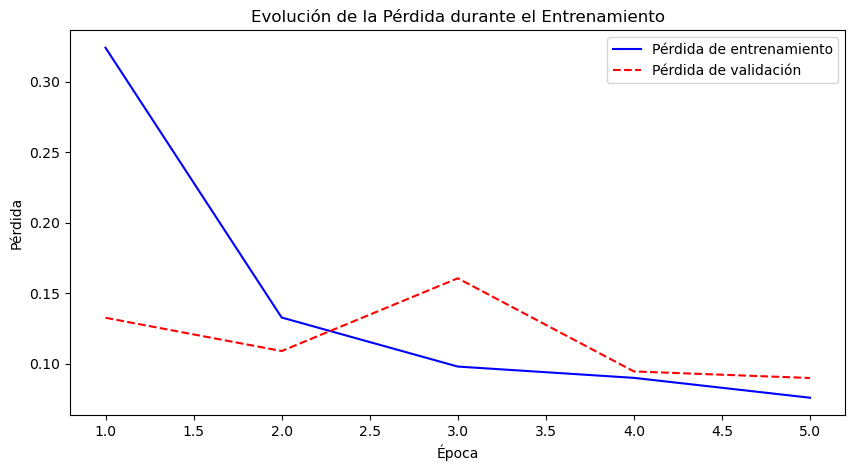

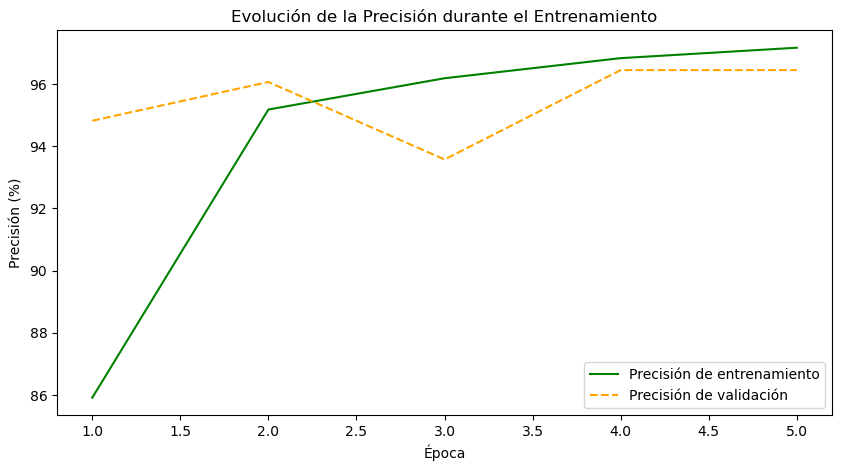

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Pérdida de entrenamiento", color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Pérdida de validación", color='red', linestyle='dashed')
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Precisión de entrenamiento", color='green')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Precisión de validación", color='orange', linestyle='dashed')
plt.title("Evolución de la Precisión durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()
plt.show()

Representaremos la arquitectura de red que mejor clasifica, usando una extensión de torch, `torchviz`.
Para ello, crearemos un `dummy`, que simule una entrada falsa para ver el comportamiento y la representación de la red. Pondremos el modelo en modo evaluación, para evitar que use técnicas de entrenamiento como Dropout o BatchNorm.

In [12]:
%pip install --upgrade torch
%pip install --upgrade torchviz

from torchviz import make_dot

# Pasamos el modelo a modo "evaluación", para desactivar las técnicas de entrenamiento como pueden ser Dropout o BatchNorm
# Así, conseguimos que represente fielmente la estructura de la red
model.eval()
dummy_input = torch.randn(1, 1, 100, 100).to(device)
output = model(dummy_input)
output.backward(torch.ones_like(output))
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH